Best Test MSE: 0.00048114884610283795
Best Q: [[1. 0.]
 [0. 1.]]
Best R: 1
Mean Squared Error (MSE): 0.0007619997492343948
Root Mean Squared Error (RMSE): 0.027604342941544447
Mean Absolute Error (MAE): 0.020863619001729016


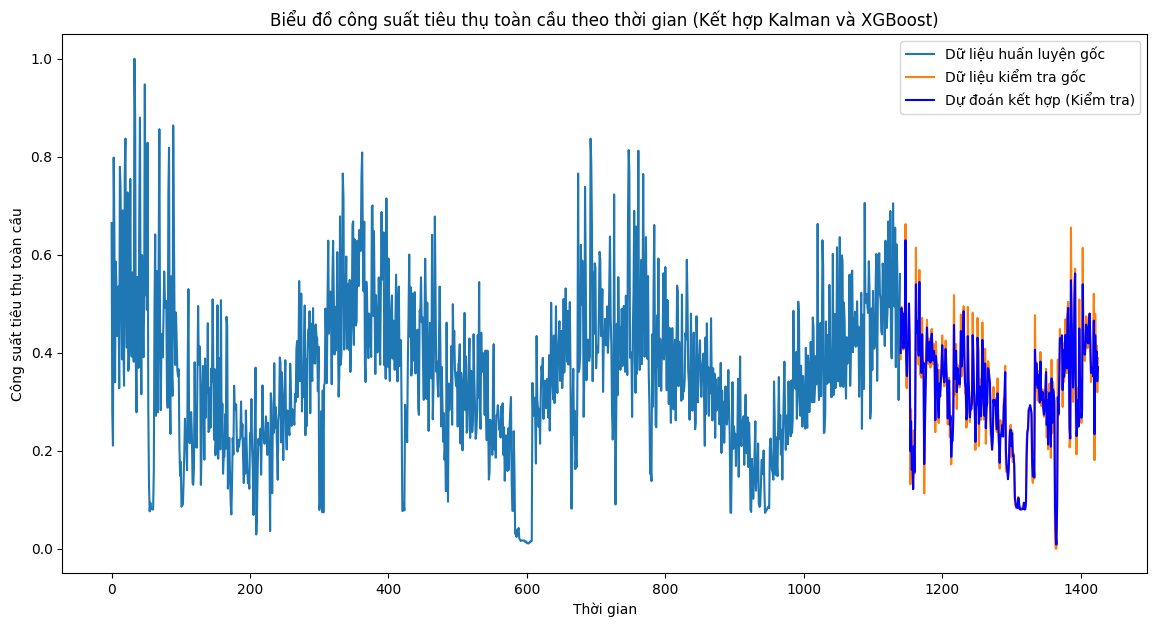

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import xgboost as xgb



# Read your data (replace with your actual data file)
data = pd.read_csv("/kaggle/input/datatime/date_data.csv")
data['timestamp'] = pd.to_datetime(data['dt']).apply(lambda x: x.timestamp())
data = data.drop(columns=['dt'])

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split data into training and test sets (80/20 split)
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Apply Kalman Filter
def apply_kalman(Q, R):
    kf = KalmanFilter(dim_x=2, dim_z=1)  
    kf.x = np.array([0., 1.])
    kf.F = np.array([[1., 1.],
                      [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = R
    kf.Q = Q

    predictions_train = []
    for measurement in train_data[:, 0]:
        kf.predict()
        kf.update(measurement)
        predictions_train.append(kf.x[0])

    predictions_test = []
    for measurement in test_data[:, 0]:
        kf.predict()
        kf.update(measurement)
        predictions_test.append(kf.x[0])

    return predictions_train, predictions_test

# Grid search for optimal Q and R
best_mse = float('inf')
best_Q = None
best_R = None

Q_values = [np.array([[0.1, 0.], [0., 0.1]]), np.array([[0.5, 0.], [0., 0.5]]), np.array([[1., 0.], [0., 1.]])]
R_values = [1, 2, 5, 10]

for Q in Q_values:
    for R in R_values:
        predictions_train, predictions_test = apply_kalman(Q, R)

        mse_test = mean_squared_error(test_data[:, 0], predictions_test)

        if mse_test < best_mse:
            best_mse = mse_test
            best_Q = Q
            best_R = R

print(f"Best Test MSE: {best_mse}")
print(f"Best Q: {best_Q}")
print(f"Best R: {best_R}")


def combine_kalman_xgboost(train_data, test_data, predictions_train, predictions_test):
  # Reshape Kalman predictions for XGBoost model
  predictions_train_reshaped = np.array(predictions_train).reshape(-1, 1)
  predictions_test_reshaped = np.array(predictions_test).reshape(-1, 1)

  # Train XGBoost model on Kalman predictions
  xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
  xgb_model.fit(predictions_train_reshaped, train_data[:, 0])

  # Make predictions using XGBoost on Kalman predictions
  xgb_predictions_train = xgb_model.predict(predictions_train_reshaped)
  xgb_predictions_test = xgb_model.predict(predictions_test_reshaped)

  # Combine predictions (e.g., 50% weight each)
  combined_train = 0.5 * train_data[:, 0] + 0.5 * xgb_predictions_train
  combined_test = 0.5 * test_data[:, 0] + 0.5 * xgb_predictions_test

  return combined_train, combined_test


# Get combined predictions
combined_train, combined_test = combine_kalman_xgboost(train_data, test_data, predictions_train, predictions_test)


# Đánh giá mô hình
mse = mean_squared_error(train_data[:, 0], combined_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(train_data[:, 0], combined_train)


print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')



plt.figure(figsize=(14, 7))
plt.plot(range(len(train_data)), train_data[:, 0], label='Dữ liệu huấn luyện gốc')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data[:, 0], label='Dữ liệu kiểm tra gốc')
plt.plot(range(len(train_data), len(train_data) + len(predictions_test)), combined_test, label='Dự đoán kết hợp (Kiểm tra)', color='blue')
plt.xlabel('Thời gian')
plt.ylabel('Công suất tiêu thụ toàn cầu')
plt.title('Biểu đồ công suất tiêu thụ toàn cầu theo thời gian (Kết hợp Kalman và XGBoost)')
plt.legend()
plt.show()
